# Using the Poisson-Boltzmann solver code with real data. 

This example uses real data generated for the 111 grain boundary orientation in gadolinium doped ceria ( $\mathrm{Gd-CeO_2}$ ). The data was generated using METADISE which is a computer program that performs atomic scale simulations of crystal structures. These simulations allow dislocations, surfaces and interfaces to be studied. METADISE has been used to study a number of grain boundaries in gadolinium doped ceria and individual defect energies and positions were calculated for gadolinium ions at cerium sites and vacancies at oxygen sites. 

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.set_of_sites import Set_of_Sites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.set_up_calculation import calculate_grid_offsets
from pyscses.grid import Grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boundary_conditions = 'periodic'
site_charges = False
systems = 'mott-schottky'
core_models = False
site_models = 'site_explicit'

In [3]:
alpha = 0.0005
conv = 1e-8
grid_x_min = -6.094e-9
grid_x_max = 5.16e-9
bulk_x_min = -5.783e-9
bulk_x_max = -2.502e-9

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp = [ 773.15 ]

In [4]:
valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.05, 0.2 ] ])
initial_guess = [ [ 0.05, 0.2 ] ]
mobilities = [ 1.0, 0.0 ]

In [5]:
data = '../input_data/Gd_CeO2_111_data.txt'

In [6]:
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = Set_of_Sites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = Set_of_Sites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
        c_o.solve_MS_approx_for_phi( valence[0] )

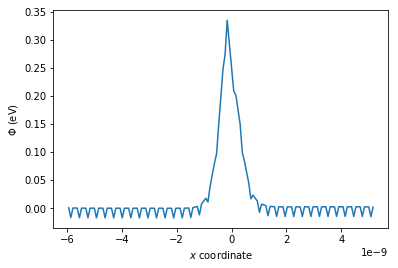

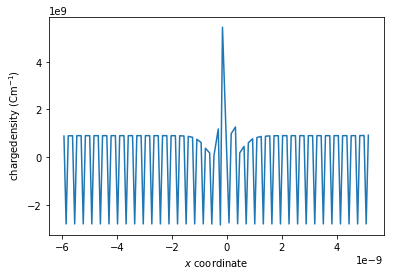

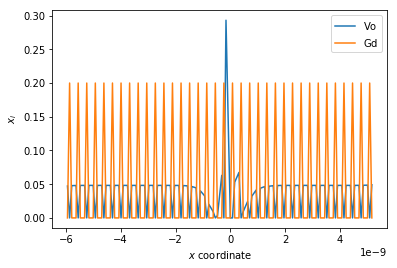

perpendicular grain boundary resistivity =  221085.07428299036
parallel grain boundary resistivity =  0.009633399877566827
space charge potential =  0.33515924784363865
Mott-Schottky approximated space charge potential =  0.524894754750353


In [7]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{Vo}$')
plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{Gd}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

print('perpendicular grain boundary resistivity = ', c_o.perpendicular_resistivity_ratio)
print('parallel grain boundary resistivity = ', c_o.parallel_resistivity_ratio)
print('space charge potential = ', max(c_o.phi))
print('Mott-Schottky approximated space charge potential = ', c_o.ms_phi)